# Исследование зависимости обучения сети от margin параметра Contrastive Loss

Обучение сиамских сетей на наборе MOT20_ext (2 пары). Используемая функция потерь - Contrastive Loss. Будет произведено обучение нескольких моделей на разных margin и выявлена зависимость обучения от margin

_другие гиперпараметры были подобраны ранее_

In [6]:
import albumentations as A
import torch
from torch.optim import Adam
import pandas as pd
from copy import deepcopy
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split

from src.config import MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN, RESULTS_PATH
from src.models import SiameseBasicCNN, models_list
from src.train import ContrastiveLoss, get_config, get_loaders, train_siamese, test_siamese, get_dataset
from src.train.utils import get_model,get_experiments, get_binary_accuracy, draw_reid_predict
from src.train.loss import ContrastiveLoss
from src.transforms import get_norm_transform, get_resize_transform

## Загрузка датасета

In [2]:
dataset_config = get_config('mot20_ext-v1c')
dataset_config

{'dataset_config': 'mot20_ext-v1c',
 'dataset': 'mot20_ext',
 'dataset_use': 0.01,
 'train_proportion': 0.15,
 'val_proportion': 0.2,
 'test_proportion': nan,
 'batch_size': 16,
 'extra_parameters': {'visibility_threshold': 1.0,
  'negative_proportion': 0.5,
  'frame_distance': 0}}

In [4]:
resize_transform = get_resize_transform((MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN)) 
norm_transform = get_norm_transform()
transform = A.Compose([resize_transform, norm_transform])

In [4]:
train_loader, val_loader, test_loader = get_loaders(dataset_config, transform=transform)

In [14]:
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/home/nick/reidentification/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

## Определить примерные границы margin

### Basic CNN, margin=0.001

In [6]:
model = SiameseBasicCNN().to(device)
lr = 1e-2
optimizer = Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
criterion = ContrastiveLoss(margin=0.001)

model, results = train_siamese(
    config=dataset_config,
    criterion=criterion,
    device=device,
    epoch_count=6,
    lr=lr,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    threshold=0.25,
    train_loader=train_loader,
    val_loader=val_loader,
)

Epoch 0/5:


/home/nick/reidentification/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 110/110 [00:17<00:00,  6.30it/s]

train Loss: 0.0292 Acc: 0.7415



100%|██████████| 33/33 [00:01<00:00, 20.98it/s]

val Loss: 0.0046 Acc: 0.7652


Model saved at basic_cnn.pth
Epoch 1/5:


100%|██████████| 110/110 [00:16<00:00,  6.80it/s]

train Loss: 0.0004 Acc: 0.7347



100%|██████████| 33/33 [00:01<00:00, 22.05it/s]

val Loss: 0.0000 Acc: 0.8295
Model saved at basic_cnn.pth
Epoch 2/5:



 30%|███       | 33/110 [00:04<00:11,  6.77it/s]


KeyboardInterrupt: 

### Basic CNN, margin=0.01

In [7]:
model = SiameseBasicCNN().to(device)
lr = 1e-2
optimizer = Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
criterion = ContrastiveLoss(margin=0.01)

model, results = train_siamese(
    config=dataset_config,
    criterion=criterion,
    device=device,
    epoch_count=6,
    lr=lr,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    threshold=0.25,
    train_loader=train_loader,
    val_loader=val_loader,
)

Epoch 0/5:


100%|██████████| 110/110 [00:16<00:00,  6.82it/s]

train Loss: 0.0313 Acc: 0.7807



100%|██████████| 33/33 [00:01<00:00, 22.50it/s]

val Loss: 0.0001 Acc: 0.8712
Model saved at basic_cnn.pth
Epoch 1/5:



100%|██████████| 110/110 [00:16<00:00,  6.80it/s]

train Loss: 0.0000 Acc: 0.7102



100%|██████████| 33/33 [00:01<00:00, 22.62it/s]

val Loss: 0.0000 Acc: 0.8352
Epoch 2/5:



  9%|▉         | 10/110 [00:01<00:16,  6.18it/s]


KeyboardInterrupt: 

### Basic CNN, margin=0.1

In [8]:
model = SiameseBasicCNN().to(device)
lr = 1e-2
optimizer = Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
criterion = ContrastiveLoss(margin=0.1)

model, results = train_siamese(
    config=dataset_config,
    criterion=criterion,
    device=device,
    epoch_count=6,
    lr=lr,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    threshold=0.25,
    train_loader=train_loader,
    val_loader=val_loader,
)

Epoch 0/5:


100%|██████████| 110/110 [00:16<00:00,  6.76it/s]

train Loss: 0.0475 Acc: 0.7466



100%|██████████| 33/33 [00:01<00:00, 22.29it/s]

val Loss: 0.0050 Acc: 0.8485
Model saved at basic_cnn.pth
Epoch 1/5:



100%|██████████| 110/110 [00:16<00:00,  6.84it/s]

train Loss: 0.0035 Acc: 0.7824



100%|██████████| 33/33 [00:01<00:00, 22.08it/s]

val Loss: 0.0040 Acc: 0.8864
Model saved at basic_cnn.pth
Epoch 2/5:



100%|██████████| 110/110 [00:16<00:00,  6.82it/s]

train Loss: 0.0034 Acc: 0.8136



100%|██████████| 33/33 [00:01<00:00, 22.48it/s]

val Loss: 0.0044 Acc: 0.8580
Epoch 3/5:



 15%|█▌        | 17/110 [00:02<00:14,  6.46it/s]


KeyboardInterrupt: 

### Basic CNN, margin=0.5

In [9]:
model = SiameseBasicCNN().to(device)
lr = 1e-2
optimizer = Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
criterion = ContrastiveLoss(margin=0.5)

model, results = train_siamese(
    config=dataset_config,
    criterion=criterion,
    device=device,
    epoch_count=6,
    lr=lr,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    threshold=0.25,
    train_loader=train_loader,
    val_loader=val_loader,
)

Epoch 0/5:


100%|██████████| 110/110 [00:16<00:00,  6.85it/s]

train Loss: 0.1223 Acc: 0.7727



100%|██████████| 33/33 [00:01<00:00, 22.12it/s]

val Loss: 0.1037 Acc: 0.8580
Model saved at basic_cnn.pth
Epoch 1/5:



100%|██████████| 110/110 [00:16<00:00,  6.83it/s]

train Loss: 0.0850 Acc: 0.8000



100%|██████████| 33/33 [00:01<00:00, 22.41it/s]

val Loss: 0.0977 Acc: 0.9186
Model saved at basic_cnn.pth
Epoch 2/5:



100%|██████████| 110/110 [00:16<00:00,  6.83it/s]

train Loss: 0.0857 Acc: 0.7966



100%|██████████| 33/33 [00:01<00:00, 23.13it/s]

val Loss: 0.0975 Acc: 0.8996
Epoch 3/5:



100%|██████████| 110/110 [00:16<00:00,  6.82it/s]

train Loss: 0.0836 Acc: 0.8114



100%|██████████| 33/33 [00:01<00:00, 21.92it/s]

val Loss: 0.0966 Acc: 0.9299
Model saved at basic_cnn.pth
Epoch 4/5:



100%|██████████| 110/110 [00:16<00:00,  6.86it/s]

train Loss: 0.0845 Acc: 0.7795



100%|██████████| 33/33 [00:01<00:00, 23.15it/s]

val Loss: 0.0946 Acc: 0.9186
Epoch 5/5:



100%|██████████| 110/110 [00:16<00:00,  6.84it/s]

train Loss: 0.0847 Acc: 0.8284



100%|██████████| 33/33 [00:01<00:00, 22.01it/s]

val Loss: 0.0960 Acc: 0.9034


## Подбор параметра

In [ ]:
for m in range(1, 6):
    model = SiameseBasicCNN().to(device)
    lr = 1e-2
    optimizer = Adam(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    criterion = ContrastiveLoss(margin=m)

    model, results = train_siamese(
        config=dataset_config,
        criterion=criterion,
        device=device,
        epoch_count=6,
        lr=lr,
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        threshold=0.25,
        train_loader=train_loader,
        val_loader=val_loader,
    )

### Интерпретация

In [49]:
df = pd.read_csv(join(RESULTS_PATH, 'experiments.csv'))
res1 = df[(df['datetime'] > '2023-05-17 16:13:29') & (df['datetime'] < '2023-05-17 16:24')]
res1

,model_name,datetime,epoch_count,optimizer,lr,gamma,step_size,loss_name,val_losses,val_accuracies,best_val_acc,best_val_loss,test_accuracy,dataset_config,extra_parameters,train_losses,train_accuracies
10,basic_cnn,2023-05-17 16:13:29.995821,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=0.5,0.10366702621633356;0.09767509500185649;0.0975...,0.8579545454545454;0.9185606060606061;0.899621...,0.929924,0.094597,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
11,basic_cnn,2023-05-17 16:16:08.357209,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=1,0.3937322163220608;0.38748486656131165;0.39237...,0.8920454545454546;0.8901515151515151;0.895833...,0.931818,0.375903,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
12,basic_cnn,2023-05-17 16:18:12.320181,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=2,1.6220077167857776;1.501405044035478;1.5712510...,0.8200757575757576;0.9015151515151515;0.922348...,0.928030,1.484149,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
13,basic_cnn,2023-05-17 16:19:21.640774,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=3,3.7105082381855357;3.536945205746275;3.4418311...,0.8314393939393939;0.8939393939393939;0.922348...,0.922348,3.441831,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
14,basic_cnn,2023-05-17 16:21:27.245222,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=4,6.333531899885698;6.176032673228871;6.33328749...,0.8712121212121212;0.9053030303030303;0.926136...,0.929924,6.133762,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
15,basic_cnn,2023-05-17 16:23:15.268691,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=5,9.332255450162021;9.461283712676078;9.44731449...,0.9223484848484849;0.9071969696969697;0.931818...,0.931818,9.222168,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN


In [53]:
margins = list(map(lambda x: float(x.split(' ')[1][2:]), list(res1['loss_name'])))
val_accuracies = list(res1['best_val_acc'])
val_losses = list(res1['best_val_loss'])

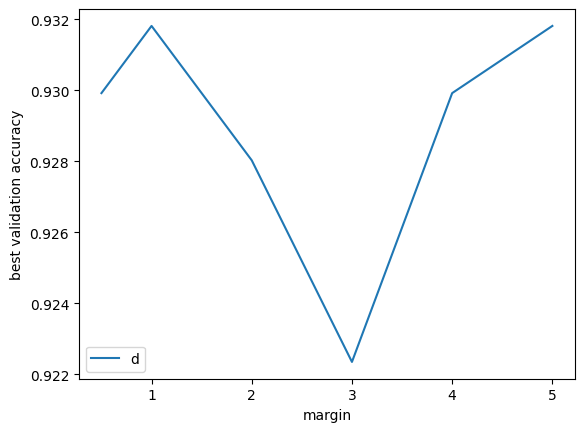

In [57]:
plt.plot(margins, val_accuracies)
plt.xlabel('margin')
plt.ylabel('best validation accuracy')

In [ ]:
for m in range(6, 10):
    model = SiameseBasicCNN().to(device)
    lr = 1e-2
    optimizer = Adam(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    criterion = ContrastiveLoss(margin=m)

    model, results = train_siamese(
        config=dataset_config,
        criterion=criterion,
        device=device,
        epoch_count=6,
        lr=lr,
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        threshold=0.25,
        train_loader=train_loader,
        val_loader=val_loader,
    )

In [10]:
df = get_experiments()
res2 = df[(df['datetime'] > '2023-05-17 16:13:29') & (df['datetime'] < '2023-05-17 21:04')]
res2

,model_name,datetime,epoch_count,optimizer,lr,gamma,step_size,loss_name,val_losses,val_accuracies,best_val_acc,best_val_loss,test_accuracy,dataset_config,extra_parameters,train_losses,train_accuracies
10,basic_cnn,2023-05-17 16:13:29.995821,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=0.5,0.10366702621633356;0.09767509500185649;0.0975...,0.8579545454545454;0.9185606060606061;0.899621...,0.929924,0.094597,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
11,basic_cnn,2023-05-17 16:16:08.357209,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=1,0.3937322163220608;0.38748486656131165;0.39237...,0.8920454545454546;0.8901515151515151;0.895833...,0.931818,0.375903,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
12,basic_cnn,2023-05-17 16:18:12.320181,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=2,1.6220077167857776;1.501405044035478;1.5712510...,0.8200757575757576;0.9015151515151515;0.922348...,0.928030,1.484149,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
13,basic_cnn,2023-05-17 16:19:21.640774,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=3,3.7105082381855357;3.536945205746275;3.4418311...,0.8314393939393939;0.8939393939393939;0.922348...,0.922348,3.441831,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
14,basic_cnn,2023-05-17 16:21:27.245222,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=4,6.333531899885698;6.176032673228871;6.33328749...,0.8712121212121212;0.9053030303030303;0.926136...,0.929924,6.133762,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
15,basic_cnn,2023-05-17 16:23:15.268691,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=5,9.332255450162021;9.461283712676078;9.44731449...,0.9223484848484849;0.9071969696969697;0.931818...,0.931818,9.222168,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN
16,basic_cnn,2023-05-17 21:00:03.709968,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=6,13.878573908950344;13.060300306840377;13.10220...,0.8939393939393939;0.9261363636363636;0.897727...,0.929924,13.051024,NaN,mot20_ext-v1c,threshold=0.25,13.192607082020153;12.551794164830989;12.40417...,0.8164772727272728;0.8204545454545454;0.813068...
17,basic_cnn,2023-05-17 21:01:33.411204,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=7,18.079176021344733;18.220480572093617;18.08935...,0.8731060606060606;0.9147727272727273;0.916666...,0.924242,17.897235,NaN,mot20_ext-v1c,threshold=0.25,17.58050719174472;16.84292718713934;16.4055915...,0.8051136363636363;0.8454545454545455;0.841477...
18,basic_cnn,2023-05-17 21:02:54.414179,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=8,22.80516474174731;23.3486483891805;23.63430419...,0.9034090909090909;0.8977272727272727;0.909090...,0.916667,22.805165,NaN,mot20_ext-v1c,threshold=0.25,22.975373545559968;21.979100903597747;22.10880...,0.8159090909090909;0.7761363636363636;0.775568...
19,basic_cnn,2023-05-17 21:03:34.423338,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=9,30.34436826994925;29.567539272886336;29.090578...,0.928030303030303;0.9375;0.9034090909090909;0....,0.937500,29.090578,NaN,mot20_ext-v1c,threshold=0.25,28.716273047707297;27.45019069151445;27.528893...,0.8005681818181818;0.8181818181818182;0.805113...


In [11]:
margins = list(map(lambda x: float(x.split(' ')[1][2:]), list(res2['loss_name'])))
val_accuracies = list(res2['best_val_acc'])
val_losses = list(res2['best_val_loss'])

Text(0, 0.5, 'best validation accuracy')

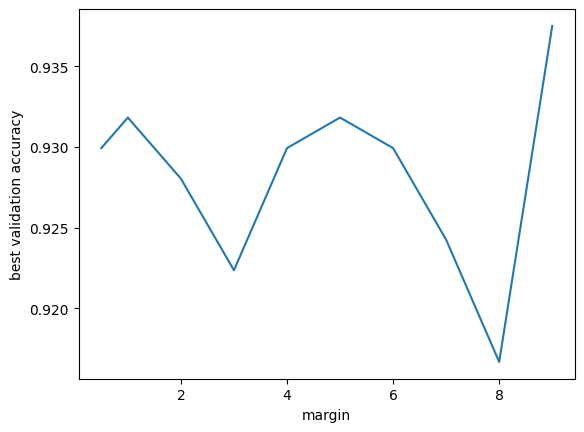

In [12]:
plt.plot(margins, val_accuracies)
plt.xlabel('margin')
plt.ylabel('best validation accuracy')

In [34]:
best_res = df[df['loss_name'] == 'ContrastiveLoss m=9']
vl = list(map(float, best_res['val_losses'].item().split(';')))
va = list(map(float, best_res['val_accuracies'].item().split(';')))
tl = list(map(float, best_res['train_losses'].item().split(';')))
ta = list(map(float, best_res['train_accuracies'].item().split(';')))
ec = best_res['epoch_count'].item()

[0, 1, 2, 3, 4, 5]

Text(0, 0.5, 'accuracy')

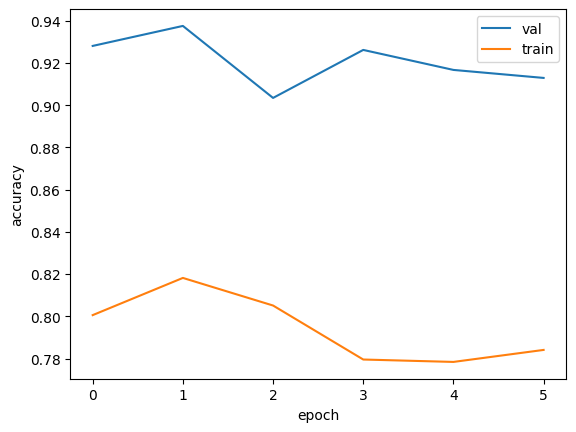

In [46]:
plt.plot(list(range(ec)), va, ta)
plt.legend(['val', 'train'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

Text(0, 0.5, 'loss')

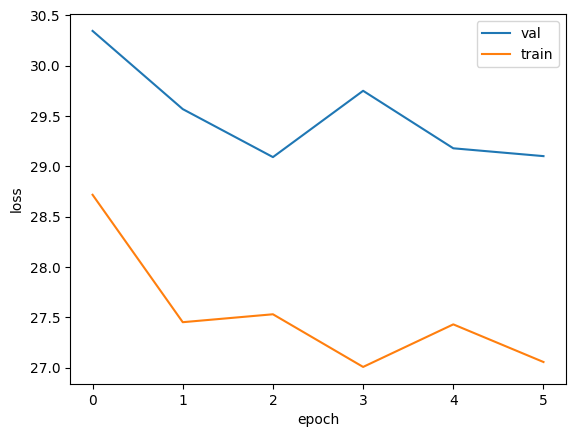

In [48]:
plt.plot(list(range(ec)), vl, tl)
plt.legend(['val', 'train'])
plt.xlabel('epoch')
plt.ylabel('loss')

## Подбор марджин с автотресхолдом

In [5]:
resize_transform = get_resize_transform((MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN)) 
norm_transform = get_norm_transform()
transform = A.Compose([resize_transform, norm_transform])
dataset_config = get_config('mot20_ext-v1d')
train_loader, val_loader, _ = get_loaders(dataset_config, transform=transform)

/home/nick/reidentification/.venv/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [ ]:
margins = range(10)
for m in margins:
    model = deepcopy(models_list['basic_cnn']).to(device)
    lr = 1e-2
    optimizer = Adam(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    criterion = ContrastiveLoss(margin=m)
    epoch_count = 6

    train_siamese(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        lr=lr,
        criterion=criterion,
        epoch_count=epoch_count,
        config=dataset_config,
        device=device,
    )

In [11]:
res = df[(df['datetime'] > '2023-05-20 16:24:09') & (df['datetime'] < '2023-05-20 16:31:24')]
res

,model_name,datetime,epoch_count,optimizer,lr,gamma,step_size,loss_name,val_losses,val_accuracies,best_val_acc,best_val_loss,test_accuracy,dataset_config,extra_parameters,train_losses,train_accuracies
22,basic_cnn,2023-05-20 16:24:09.337878,6,Adam,0.01,NaN,NaN,ContrastiveLoss m=0,0.0004630268584670765;1.844191666307216e-05;7....,0.8452380952380952;0.8333333333333334;0.830357...,0.851190,0.000003,NaN,mot20_ext-v1d,thresholds=0.0014224081533029675;0.00030342757...,0.04113989466053284;0.0001051631390677274;1.09...,NaN
23,basic_cnn,2023-05-20 16:24:52.437120,6,Adam,0.01,NaN,NaN,ContrastiveLoss m=1,0.3777174594856444;0.39326126660619465;0.39663...,0.8303571428571428;0.8154761904761905;0.818452...,0.848214,0.377717,NaN,mot20_ext-v1d,thresholds=0.015507536008954048;0.026822168380...,0.4157000230304126;0.3736413600801051;0.385329...,NaN
24,basic_cnn,2023-05-20 16:25:18.532505,6,Adam,0.01,NaN,NaN,ContrastiveLoss m=2,1.456988255182902;1.5556208122344244;1.4958902...,0.8184523809523809;0.8779761904761905;0.785714...,0.877976,1.456988,NaN,mot20_ext-v1d,thresholds=0.04098544642329216;0.0599499233067...,1.4434413875656567;1.432525405938598;1.4532768...,NaN
25,basic_cnn,2023-05-20 16:26:36.310563,6,Adam,0.01,NaN,NaN,ContrastiveLoss m=3,3.7002851963043213;3.601610126949492;3.4823596...,0.8333333333333334;0.8571428571428572;0.854166...,0.866071,3.414124,NaN,mot20_ext-v1d,thresholds=0.07356057316064835;0.0838013291358...,3.399118661880493;3.2936905499162346;3.1572184...,NaN
26,basic_cnn,2023-05-20 16:27:37.379148,6,Adam,0.01,NaN,NaN,ContrastiveLoss m=4,5.857058093661354;5.895547265098209;6.12524395...,0.8214285714285714;0.8005952380952381;0.830357...,0.836310,5.857058,NaN,mot20_ext-v1d,thresholds=0.07203368842601776;0.0837642252445...,5.929662485232298;5.639093878625453;5.66695757...,NaN
27,basic_cnn,2023-05-20 16:27:46.016896,6,Adam,0.01,NaN,NaN,ContrastiveLoss m=5,9.77270069576445;9.742881298065186;9.753235044...,0.8303571428571428;0.8273809523809523;0.797619...,0.830357,9.146684,NaN,mot20_ext-v1d,thresholds=0.07906311750411987;0.0964957997202...,9.305743409299302;9.1776779547505;8.8286141417...,NaN
28,basic_cnn,2023-05-20 16:29:04.417765,6,Adam,0.01,NaN,NaN,ContrastiveLoss m=6,15.553819202241444;13.668941724868048;14.05115...,0.8244047619047619;0.8214285714285714;0.821428...,0.851190,13.396208,NaN,mot20_ext-v1d,thresholds=0.17382009327411652;0.1479948312044...,13.384039862402554;12.916547797192102;12.56755...,NaN
29,basic_cnn,2023-05-20 16:29:39.273887,6,Adam,0.01,NaN,NaN,ContrastiveLoss m=7,19.68473634265718;18.579487119402206;19.430807...,0.8125;0.8333333333333334;0.8065476190476191;0...,0.833333,17.789325,NaN,mot20_ext-v1d,thresholds=0.13525080680847168;0.1448586285114...,17.683415774641364;17.39971613609928;17.063814...,NaN
30,basic_cnn,2023-05-20 16:30:23.052789,6,Adam,0.01,NaN,NaN,ContrastiveLoss m=8,25.888938358851842;23.795784541538783;24.26931...,0.8452380952380952;0.8184523809523809;0.836309...,0.845238,23.657410,NaN,mot20_ext-v1d,thresholds=0.19630469381809235;0.1761366277933...,22.91867162989474;22.466060353421618;21.719288...,NaN
31,basic_cnn,2023-05-20 16:31:23.251605,6,Adam,0.01,NaN,NaN,ContrastiveLoss m=9,31.95625096275693;30.45148686000279;31.2986570...,0.8333333333333334;0.8839285714285714;0.848214...,0.883929,30.451487,NaN,mot20_ext-v1d,thresholds=0.17347583174705505;0.1718134433031...,29.16424963940149;28.982418827626898;28.852888...,NaN


Text(0.5, 0, 'margin')

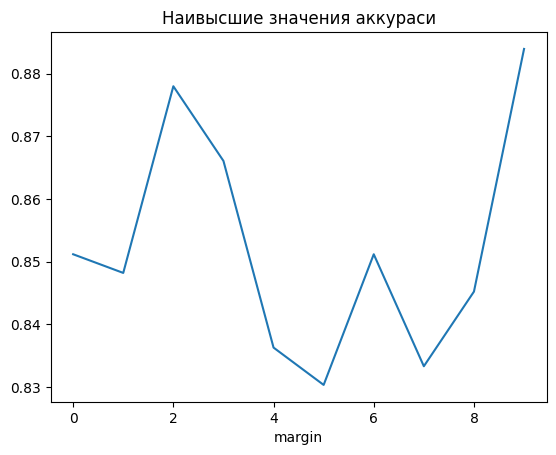

In [21]:
margins = range(10)
va = list(res['best_val_acc'])
plt.plot(margins, va)
plt.title('Наивысшие значения аккураси')
plt.xlabel('margin')

Text(0.5, 0, 'epoch')

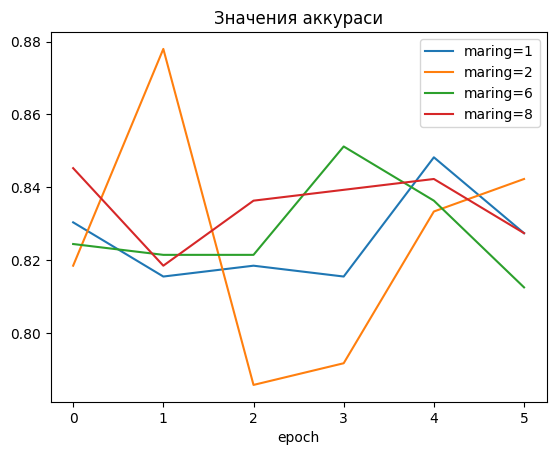

In [48]:
best_margins = [1, 2, 6, 8]
mask = res['loss_name'].apply(lambda x: int(x.split('=')[1]) in best_margins)
vas = list(map(lambda va: list(map(float, va.split(';'))), list(res[mask]['val_accuracies'])))
for va in vas:
    plt.plot(list(range(epoch_count)), va)

plt.title('Значения аккураси')
plt.legend(['maring=1', 'maring=2', 'maring=6', 'maring=8'])
plt.xlabel('epoch')

## Проверка на тесте

In [7]:
resize_transform = get_resize_transform((MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN)) 
norm_transform = get_norm_transform()
transform = A.Compose([resize_transform, norm_transform])
test_dataset_config = get_config('mot20_ext-test-v2')
test_set, _ = random_split(get_dataset(test_dataset_config, transform), [
                          test_dataset_config['dataset_use'], 1 - test_dataset_config['dataset_use']])
test_loader = DataLoader(test_set)

In [20]:
res = df[df['model_name'] == 'basic_cnn']
max = res['best_val_acc'].max()
mask = res['best_val_acc'].apply(lambda x: x == max)
best = res[mask]
best1 = best[best['datetime'] == '2023-05-16 21:12:15.115694']
best2 = best[best['datetime'] == '2023-05-16 21:13:44.219291']
best

,model_name,datetime,epoch_count,optimizer,lr,gamma,step_size,loss_name,val_losses,val_accuracies,best_val_acc,best_val_loss,test_accuracy,dataset_config,extra_parameters,train_losses,train_accuracies
3,basic_cnn,2023-05-16 21:12:15.115694,6,Adam,0.001,NaN,NaN,ContrastiveLoss,1.7107092142105103;1.6221161603927612;1.626214...,0.8375;0.9;0.925;0.95;0.7875;0.925,0.95,1.585436,NaN,mot20_ext-v1b,threshold=0.25,NaN,NaN
4,basic_cnn,2023-05-16 21:13:44.219291,6,Adam,0.010,0.1,2.0,ContrastiveLoss,1.6568951606750488;1.6641317844390868;1.532974...,0.85;0.85;0.9125;0.9125;0.95;0.9,0.95,1.532974,NaN,mot20_ext-v1b,threshold=0.25,NaN,NaN


In [12]:
model = get_model(best1)
threshold1 = float(best1['extra_parameters'].item().split('=')[1].split(',')[0])
threshold1

0.25

In [15]:
td1 = test_siamese(model, test_loader, device)

100%|██████████| 6946/6946 [00:39<00:00, 174.42it/s]


0.939101641232364

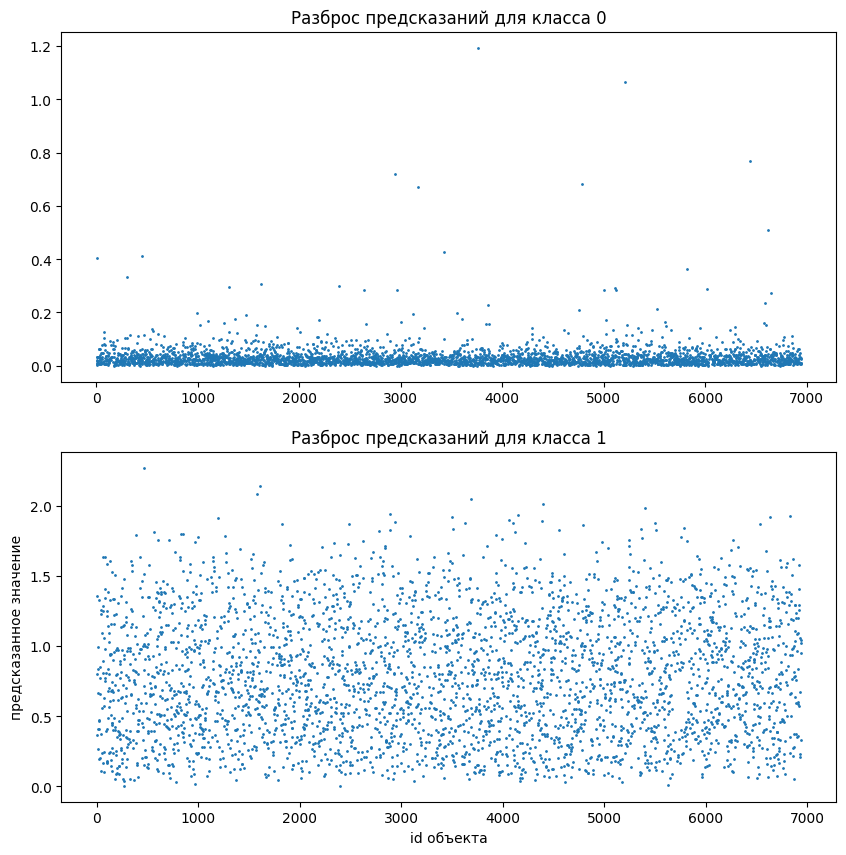

In [16]:
draw_reid_predict(td1)
get_binary_accuracy(td1, threshold1)

In [17]:
model = get_model(best2)
threshold2 = float(best2['extra_parameters'].item().split('=')[1].split(',')[0])
threshold2

0.25

In [18]:
td2 = test_siamese(model, test_loader, device)

100%|██████████| 6946/6946 [00:41<00:00, 166.29it/s]


0.9588252231500144

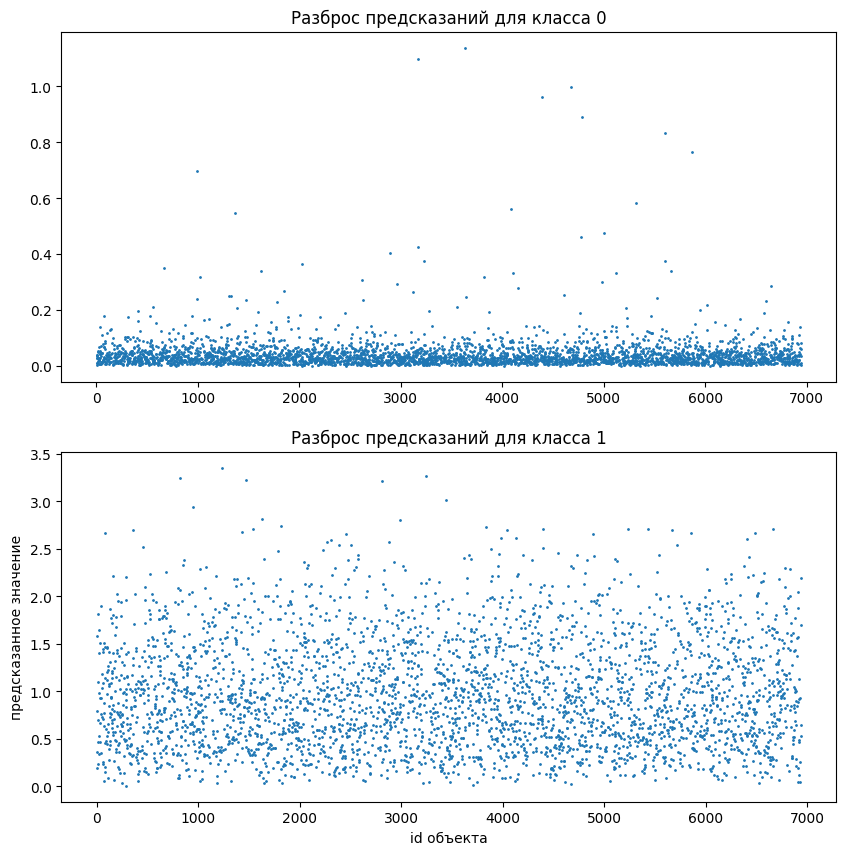

In [19]:
draw_reid_predict(td2)
get_binary_accuracy(td2, threshold2)

In [21]:
best3 = df[df['datetime'] == '2023-05-20 16:25:18.532505']
threshold3 = list(best3['extra_parameters'].item().split('=')[1].split(';'))
best_acc = best3['best_val_acc']
acc = list(map(float, best3['val_accuracies'].item().split(';')))
i = acc.index(best_acc.item())
threshold3 = float(threshold3[i])
model = get_model(best3, device)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [120]:
td3 = test_siamese(model, test_loader, device)

100%|██████████| 6946/6946 [00:37<00:00, 185.82it/s]


0.5060466455513966

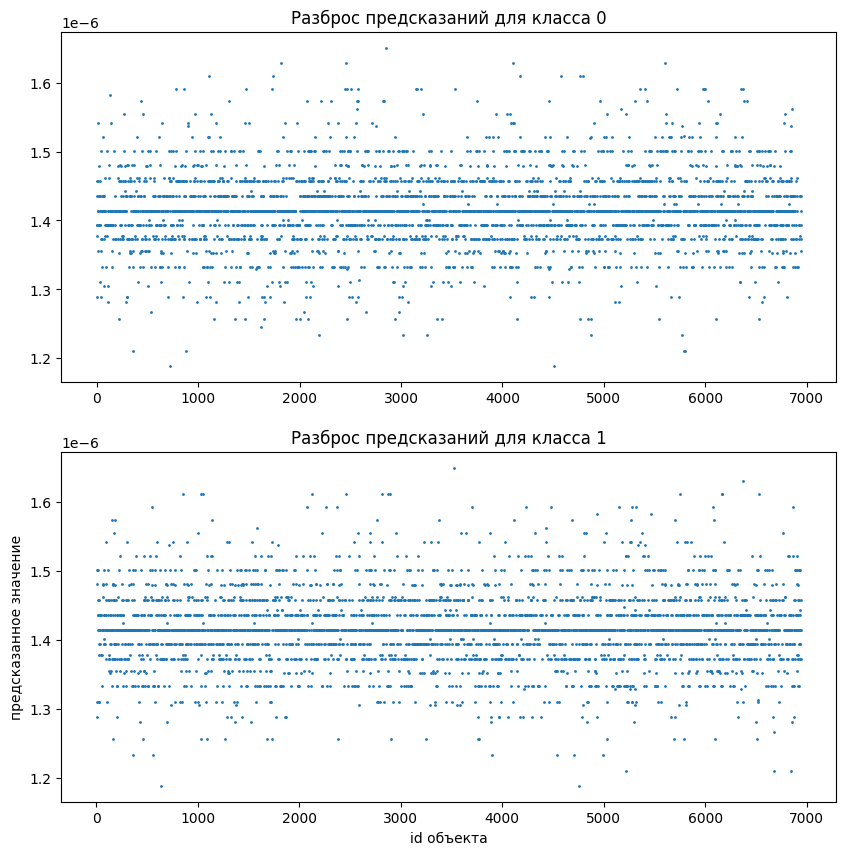

: 

In [124]:
draw_reid_predict(td3)
get_binary_accuracy(td3, threshold3)